# Calculate Dynamic information like actions, eccentricity etc.

In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import astropy.units as u
from astropy.table import Table, join

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import corner
from matplotlib.colors import LogNorm

In [2]:
setup = 'allstar'
version = 240207

dr4_data = Table.read('galah_dr4_'+setup+'_'+str(version)+'.fits')
gaia_dr3 = Table.read('../auxiliary_information/dr60_231004_ebv_wise_tmass_gaiadr3corr_xmatch.fits')
# remove bad tmass_id, minimise to important entries and join
gaia_dr3 = gaia_dr3[['sobject_id','pmra','pmdec']]
dr4_data = join(dr4_data, gaia_dr3, keys='sobject_id', join_type='left',metadata_conflicts='silent')

output = Table()
for key in ['sobject_id','tmass_id','gaiadr3_source_id']:
    output[key] = dr4_data[key]
    
# Identify default input
output['ra'] = dr4_data['ra'] * u.deg
output['dec'] = dr4_data['dec'] * u.deg
output['r_med'] = dr4_data['r_med'] * u.pc
output['pmra'] = dr4_data['pmra']
output['pmdec'] = dr4_data['pmdec']
output['rv'] = dr4_data['rv_comp_1'] * u.km/u.s

# overwrite vrad, if GALAH DR4 infinite, but Gaia DR3 available
no_galah_dr4_vrad_but_gaia_dr3 = (
    np.isnan(dr4_data['rv_comp_1']) &
    np.isfinite(dr4_data['rv_gaia_dr3'])
)
output['rv'][no_galah_dr4_vrad_but_gaia_dr3] = dr4_data['rv_gaia_dr3'][no_galah_dr4_vrad_but_gaia_dr3]

# identify which entries are finite and can be used to compute dynamics
useful = (
    np.isfinite(output['ra']) &
    np.isfinite(output['dec']) &
    np.isfinite(output['r_med']) &
    np.isfinite(output['pmra']) &
    np.isfinite(output['pmdec']) &
    np.isfinite(output['rv'])
)
useful_indices = np.arange(len(output['sobject_id']))[useful]

for key in [
    'X_XYZ','Y_XYZ','Z_XYZ'
]:
    output[key] = np.ones(len(output['sobject_id']),dtype=np.float32)*u.kpc; output[key][:] = np.nan
for key in [
    'U_UVW','V_UVW','W_UVW',
]:
    output[key] = np.ones(len(output['sobject_id']),dtype=np.float32)*u.km/u.s; output[key][:] = np.nan
for key in [
    'R_Rzphi'
]:
    output[key] = np.ones(len(output['sobject_id']),dtype=np.float32)*u.kpc; output[key][:] = np.nan
for key in [
    'phi_Rzphi'
]:
    output[key] = np.ones(len(output['sobject_id']),dtype=np.float32)*u.rad; output[key][:] = np.nan
for key in [
    'z_Rzphi'
]:
    output[key] = np.ones(len(output['sobject_id']),dtype=np.float32)*u.kpc; output[key][:] = np.nan
for key in [
    'vR_Rzphi','vT_Rzphi','vz_Rzphi',
]:
    output[key] = np.ones(len(output['sobject_id']),dtype=np.float32)*u.km/u.s; output[key][:] = np.nan
for key in [
    'J_R','L_Z','J_Z'
]:
    output[key] = np.ones(len(output['sobject_id']),dtype=np.float32)*u.kpc*u.km/u.s; output[key][:] = np.nan
for key in [
    'omega_R','omega_phi','omega_z',
    'angle_R','angle_phi','angle_z'
]:
    output[key] = np.ones(len(output['sobject_id']),dtype=np.float32); output[key][:] = np.nan

key = 'ecc'; output[key] = np.ones(len(output['sobject_id']),dtype=np.float32); output[key][:] = np.nan
key = 'zmax'; output[key] = np.ones(len(output['sobject_id']),dtype=np.float32)*u.kpc; output[key][:] = np.nan
key = 'R_peri'; output[key] = np.ones(len(output['sobject_id']),dtype=np.float32)*u.kpc; output[key][:] = np.nan
key = 'R_ap'; output[key] = np.ones(len(output['sobject_id']),dtype=np.float32)*u.kpc; output[key][:] = np.nan


### Galpy initialization

We are using the McMillan17 potential from McMillan, 2017, MNRAS, 465, 76.  
Contrary to galpy, its normalisation parameters are:  
r_gc = 8.21 kpc (galpy: 8.0 kpc, Gravity Collaboration, 2018, A&A, 615, 15: 8.178 kpc).  
v_gc = 233.1 km/s (galpy: 220 km/s)

In [3]:
import galpy
#from galpy.potential import MWPotential2014 as pot
from galpy.potential.mwpotentials import McMillan17 as pot
from galpy.actionAngle import actionAngleStaeckel, actionAngleSpherical
from galpy.orbit import Orbit

# Reference values
#r_galactic_centre = 8.178*u.kpc # Gravity Collaboration, 2019, A&A, 625, 10
r_galactic_centre = 8.21*u.kpc # McMillan Potential, 2017
z_galactic_plane = 25.0*u.pc # Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529

print('Reference frame:')
print('R_GC = '+str(r_galactic_centre)+' (McMillan, 2017, MNRAS, 465, 76)')
print('phi_GC = '+str(0*u.rad))
print('z_GC = '+str(z_galactic_plane)+' (Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529)')

v_total_sun = (np.tan(6.379*u.mas)*r_galactic_centre/u.yr).to(u.km/u.s) # pm_l by Reid & Brunthaler 2004, ApJ, 616, 872
print('V_total_sun: = '+"{:.2f}".format(v_total_sun)+' (Reid & Brunthaler 2004, ApJ, 616, 872)')
v_peculiar = [11.1, 15.17, 7.25]*u.km/u.s # U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829, V so that V = V_total-V_sun
print('V_peculiar = ',(v_peculiar),' (U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829)')
print('V-component of V_peculiar = 15.17 km/s, instead of 12.24 km/s by Schoenrich et al. (2010), for matching v_circular')
v_circular = np.round(v_total_sun-v_peculiar[1],1)
print('V_circular = ',"{:.2f}".format(v_circular),' (McMillan, 2017, MNRAS, 465, 76)')

aAS = actionAngleStaeckel(
        pot   = pot,        #potential                                                                                                                                                                      
        delta = 0.45,       #focal length of confocal coordinate system                                                                                                                            
        c     = True        #use C code (for speed)                                                                                                                                                         
        )

# #(RA = 17:45:37.224 h:m:s, Dec = −28:56:10.23 deg) (Reid& Brunthaler 2004)

Reference frame:
R_GC = 8.21 kpc (McMillan, 2017, MNRAS, 465, 76)
phi_GC = 0.0 rad
z_GC = 25.0 pc (Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529)
V_total_sun: = 248.27 km / s (Reid & Brunthaler 2004, ApJ, 616, 872)
V_peculiar =  [11.1  15.17  7.25] km / s  (U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829)
V-component of V_peculiar = 15.17 km/s, instead of 12.24 km/s by Schoenrich et al. (2010), for matching v_circular
V_circular =  233.10 km / s  (McMillan, 2017, MNRAS, 465, 76)


In [4]:
calculate_sun = True

if calculate_sun:
    sun = dict()

    # Create the Orbit instance
    o = Orbit(
        #ra, dec, dist, pm_ra, pm_dec, v_los
        vxvv=[0.*u.deg,0.*u.deg,0.*u.kpc,0.*u.mas/u.yr, 0.*u.mas/u.yr,0.*u.km/u.s],
        ro=r_galactic_centre,
        vo=v_circular,
        zo=z_galactic_plane,
        solarmotion=[-11.1, 15.17, 7.25]*u.km/u.s,
        #solarmotion='schoenrich',
        radec=True
    )

    #Galactocentric coordinates:
    sun['X_XYZ'] = o.helioX()#*u.kpc        
    sun['Y_XYZ'] = o.helioY()#*u.kpc
    sun['Z_XYZ'] = o.helioZ()#*u.kpc
    sun['U_UVW'] = o.U()#*u.km/u.s
    sun['V_UVW'] = o.V()#*u.km/u.s
    sun['W_UVW'] = o.W()#*u.km/u.s
    sun['R_Rzphi'] = o.R()#*u.kpc
    sun['phi_Rzphi'] = o.phi()#*u.rad
    sun['z_Rzphi'] = o.z()#*u.kpc
    sun['vR_Rzphi'] = o.vR()#*u.km/u.s
    sun['vT_Rzphi'] = o.vT()#*u.km/u.s        
    sun['vz_Rzphi'] = o.vz()#*u.km/u.s

    try:
        sun['J_R'], sun['L_Z'],sun['J_Z'], sun['omega_R'], sun['omega_phi'], sun['omega_z'], sun['angle_R'], sun['angle_phi'], sun['angle_z'] = aAS.actionsFreqsAngles(
            #R,vR,vT,z,vz[,phi]
            sun['R_Rzphi']*u.kpc,
            sun['vR_Rzphi']*u.km/u.s,
            sun['vT_Rzphi']*u.km/u.s,
            sun['z_Rzphi']*u.kpc,
            sun['vz_Rzphi']*u.km/u.s,
            sun['phi_Rzphi']*u.rad,
            ro=r_galactic_centre,vo=v_circular
        )
    except:
        sun['omega_R'] = [np.nan]
        sun['omega_phi'] = [np.nan]
        sun['omega_z'] = [np.nan]
        sun['angle_R'] = [np.nan]
        sun['angle_phi'] = [np.nan]
        sun['angle_z'] = [np.nan]
        try:
            sun['J_R'], sun['L_Z'],sun['J_Z'] = aAS(
            #R,vR,vT,z,vz[,phi]
            sun['R_Rzphi']*u.kpc,
            sun['vR_Rzphi']*u.km/u.s,
            sun['vT_Rzphi']*u.km/u.s,
            sun['z_Rzphi']*u.kpc,
            sun['vz_Rzphi']*u.km/u.s,
            sun['phi_Rzphi']*u.rad,
            ro=r_galactic_centre,vo=v_circular
        )
        except:
            sun['J_R'] = [np.nan]
            sun['L_Z'] = [np.nan]
            sun['J_Z'] = [np.nan]

    try:
        sun['ecc'], sun['zmax'], sun['R_peri'], sun['R_ap'] = aAS.EccZmaxRperiRap(
            #R,vR,vT,z,vz[,phi]
            sun['R_Rzphi']*u.kpc,
            sun['vR_Rzphi']*u.km/u.s,
            sun['vT_Rzphi']*u.km/u.s,
            sun['z_Rzphi']*u.kpc,
            sun['vz_Rzphi']*u.km/u.s,
            sun['phi_Rzphi']*u.rad,
            ro=r_galactic_centre,vo=v_circular
        )         
        sun['zmax']
        sun['R_peri']
        sun['R_peri']

    except:
        sun['ecc'] = [np.nan]
        sun['zmax'] = [np.nan]
        sun['R_peri'] = [np.nan]
        sun['R_ap'] = [np.nan]

    sun['Energy'] = o.E(pot=pot,ro=r_galactic_centre,vo=v_circular,zo=z_galactic_plane)

    print('Solar values:')
    print('X,Y,Z: '+"{:.2f}".format(sun['X_XYZ'])+' '+"{:.2f}".format(sun['Y_XYZ'])+' '+"{:.2f}".format(sun['Z_XYZ']))
    print('U,V,W: '+"{:.2f}".format(sun['U_UVW'])+' '+"{:.2f}".format(sun['V_UVW'])+' '+"{:.2f}".format(sun['W_UVW']))
    print('R,phi,z: '+"{:.2f}".format(sun['R_Rzphi'])+' '+"{:.2f}".format(sun['phi_Rzphi'])+' '+"{:.2f}".format(sun['z_Rzphi']))
    print('vR,vT,vz: '+"{:.2f}".format(sun['vR_Rzphi'])+' '+"{:.2f}".format(sun['vT_Rzphi'])+' '+"{:.2f}".format(sun['vz_Rzphi']))
    print('J_R,L_Z,J_Z: '+"{:.2f}".format(sun['J_R'][0])+' '+"{:.2f}".format(sun['L_Z'][0])+' '+"{:.2f}".format(sun['J_Z'][0]))
    print('Omega R/phi/z: '+"{:.2f}".format(sun['omega_R'][0])+' '+"{:.2f}".format(sun['omega_phi'][0])+' '+"{:.2f}".format(sun['omega_z'][0]))
    print('Angles R/phi/z: '+"{:.2f}".format(sun['angle_R'][0])+' '+"{:.2f}".format(sun['angle_phi'][0])+' '+"{:.2f}".format(sun['angle_z'][0]))
    print('ecc, zmax, R_peri, R_apo: '+"{:.2f}".format(sun['ecc'][0])+' '+"{:.2f}".format(sun['zmax'][0])+' '+"{:.2f}".format(sun['R_peri'][0])+' '+"{:.2f}".format(sun['R_ap'][0]))
    print('Energy: '+"{:.2f}".format(sun['Energy']))

Solar values:
X,Y,Z: -0.00 -0.00 -0.00
U,V,W: 0.00 0.00 0.00
R,phi,z: 8.21 0.00 0.03
vR,vT,vz: -11.10 248.27 7.25
J_R,L_Z,J_Z: 7.73 2038.30 0.37
Omega R/phi/z: 38.00 27.07 68.36
Angles R/phi/z: 5.86 0.05 0.35
ecc, zmax, R_peri, R_apo: 0.07 0.11 8.15 9.43
Energy: -152783.43


In [5]:
for x in range(0,int(np.floor(len(output['sobject_id'][useful])/10000.+1))):

    print(x*10000,(x+1)*10000)
    calculation = useful_indices[x*10000:min([(x+1)*10000,len(useful_indices)])]
    
    ra     = list(output['ra'][calculation]) * u.deg
    dec    = list(output['dec'][calculation]) * u.deg
    dist   = list(output['r_med'][calculation]) * u.pc
    pm_ra  = list(output['pmra'][calculation]) * u.mas/u.yr
    pm_dec = list(output['pmdec'][calculation]) * u.mas/u.yr
    v_los  = list(output['rv'][calculation]) * u.km/u.s

    o = Orbit(
            vxvv=[ra,dec,dist,pm_ra, pm_dec,v_los],
            ro=r_galactic_centre,
            vo=v_circular,
            zo=z_galactic_plane,
            solarmotion=[-11.1, 15.17, 7.25]*u.km/u.s,
            radec=True
        )


    output['X_XYZ'][calculation] = o.helioX()        
    output['Y_XYZ'][calculation] = o.helioY()
    output['Z_XYZ'][calculation] = o.helioZ()
    output['U_UVW'][calculation] = o.U()
    output['V_UVW'][calculation] = o.V()
    output['W_UVW'][calculation] = o.W()
    output['R_Rzphi'][calculation] = o.R()
    output['phi_Rzphi'][calculation] = o.phi()
    output['z_Rzphi'][calculation] = o.z()
    output['vR_Rzphi'][calculation] = o.vR()
    output['vT_Rzphi'][calculation] = o.vT()
    output['vz_Rzphi'][calculation] = o.vz()

    actionsFreqsAngles = aAS.actionsFreqsAngles(
        o,
        # orbit o, representing
        #R,vR,vT,z,vz[,phi]
    #     output['R_Rzphi'][calculation],
    #     output['vR_Rzphi'][calculation],
    #     output['vT_Rzphi'][calculation],
    #     output['z_Rzphi'][calculation],
    #     output['vz_Rzphi'][calculation],
    #     output['phi_Rzphi'][calculation],
        ro=r_galactic_centre,vo=v_circular
    )

    output['J_R'][calculation] = actionsFreqsAngles[0]
    output['L_Z'][calculation] = actionsFreqsAngles[1]
    output['J_Z'][calculation] = actionsFreqsAngles[2]
    output['omega_R'][calculation] = actionsFreqsAngles[3]
    output['omega_phi'][calculation] = actionsFreqsAngles[4]
    output['omega_z'][calculation] = actionsFreqsAngles[5]
    output['angle_R'][calculation] = actionsFreqsAngles[6]
    output['angle_phi'][calculation] = actionsFreqsAngles[7]
    output['angle_z'][calculation] = actionsFreqsAngles[8]

    EccZmaxRperiRap = aAS.EccZmaxRperiRap(
        o,
        # orbit o, representing
        #R,vR,vT,z,vz[,phi]
        # output['R_Rzphi'][calculation],
        # output['vR_Rzphi'][calculation],
        # output['vT_Rzphi'][calculation],
        # output['z_Rzphi'][calculation],
        # output['vz_Rzphi'][calculation],
        # output['phi_Rzphi'][calculation],
        ro=r_galactic_centre,vo=v_circular
    )

    output['ecc'][calculation] = EccZmaxRperiRap[0]
    output['zmax'][calculation] = EccZmaxRperiRap[1]
    output['R_peri'][calculation] = EccZmaxRperiRap[2]
    output['R_ap'][calculation] = EccZmaxRperiRap[3]

0 10000
/home/buder/.local/lib/python3.8/site-packages/galpy/util/coords.py:2017: RuntimeWarning: overflow encountered in sinh
  R = delta * numpy.sinh(u) * numpy.sin(v)

/home/buder/.local/lib/python3.8/site-packages/galpy/util/coords.py:2018: RuntimeWarning: overflow encountered in cosh
  z = delta * numpy.cosh(u) * numpy.cos(v)

/home/buder/.local/lib/python3.8/site-packages/galpy/actionAngle/actionAngleStaeckel.py:497: RuntimeWarning: invalid value encountered in add
  e = (rap - rperi) / (rap + rperi)

10000 20000
20000 30000
30000 40000
40000 50000
50000 60000
60000 70000
70000 80000
80000 90000
90000 100000
100000 110000
110000 120000
120000 130000
130000 140000
140000 150000
150000 160000
160000 170000
170000 180000
180000 190000
190000 200000
200000 210000
210000 220000
220000 230000
230000 240000
240000 250000
250000 260000
260000 270000
270000 280000
280000 290000
290000 300000
300000 310000
310000 320000
320000 330000
330000 340000
340000 350000
350000 360000
360000 370000


In [6]:
output.write('galah_dr4_vac_dynamics_'+str(version)+'.fits',overwrite=True)

In [7]:
gcs = Table.read('../auxiliary_information/VasilievBaumgardt_2021_MNRAS_505_5978_cluster_source_id_memberprob0p7.fits')
gcs['gaiadr3_source_id'] = gcs['source_id']
gcs_dr4 = join(gcs, output, keys='gaiadr3_source_id')
gcs_dr4 = gcs_dr4[np.isfinite(gcs_dr4['L_Z'])]

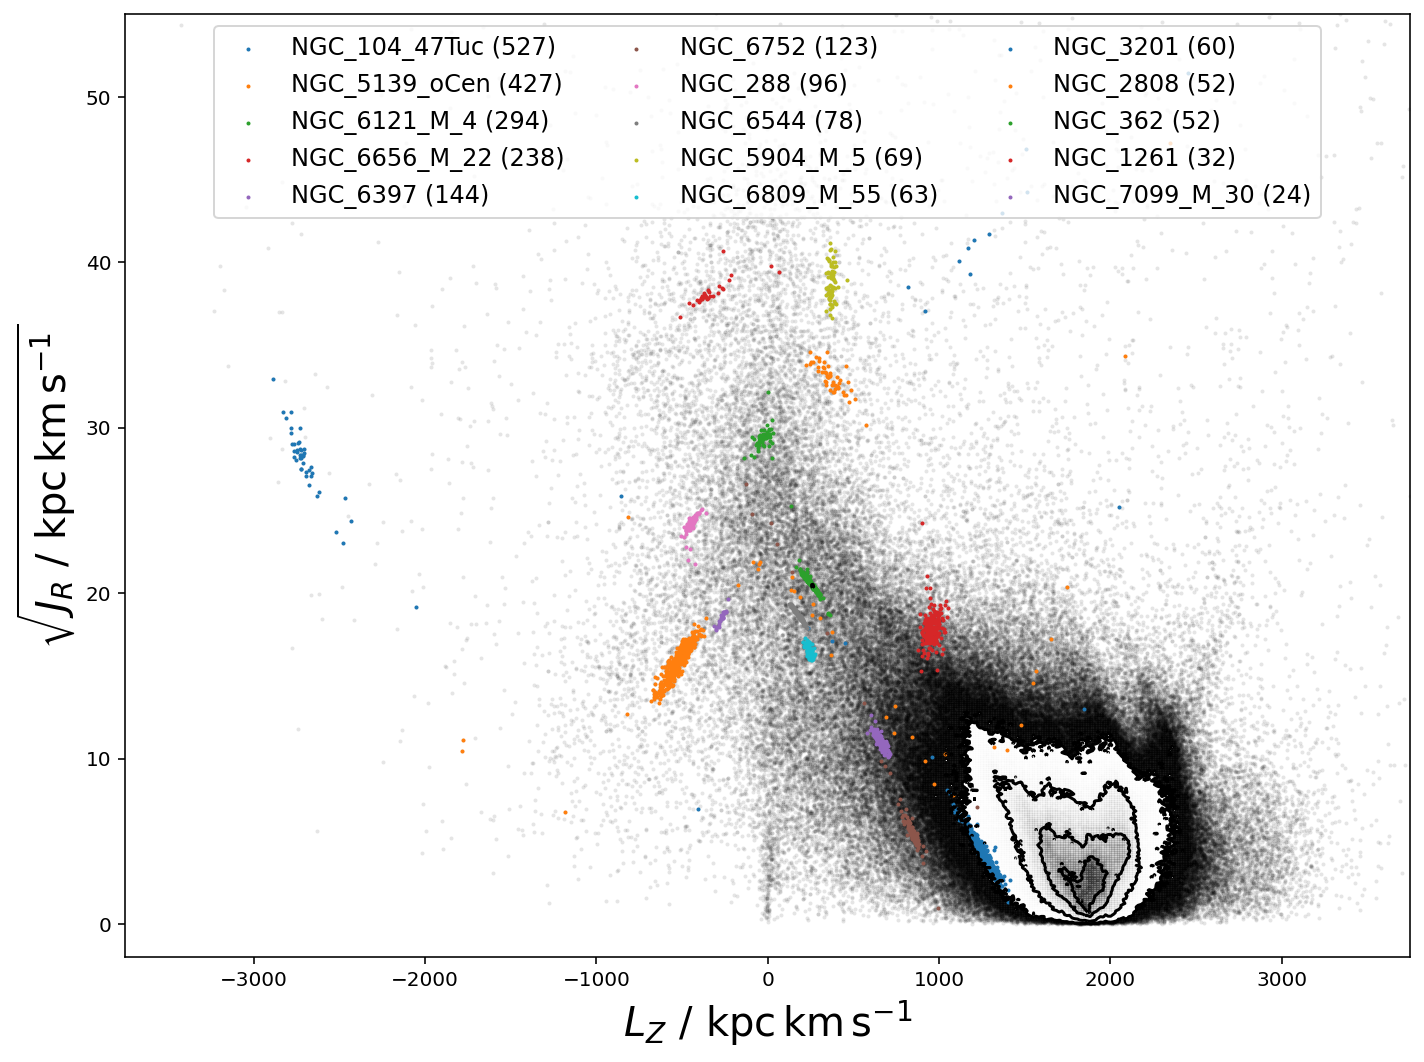

In [104]:
f,ax = plt.subplots(figsize=(10,7.5))

use = np.isfinite(output['L_Z'])
corner.hist2d(
    output['L_Z'][use],
    np.sqrt(output['J_R'][use]),
    range = [(-3750,3750),(-2,55)],
    bins = 500,
    ax=ax
)
ax.set_xlabel(r'$L_Z~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=20)
ax.set_ylabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$',fontsize=20)

gcs = Table()
gcs['cluster'], gcs['counts'] = np.unique(gcs_dr4['cluster'],return_counts=True)
gcs.sort('counts',reverse=True)

plt.tight_layout()
plt.savefig('../validation/figures/galah_dr4_lz_jr_without_gcs.png',dpi=200,bbox_inches='tight')

nr = 0
for gc in gcs['cluster']:
    in_cluster = (gcs_dr4['cluster'] == gc) & np.isfinite(gcs_dr4['L_Z'])
    if len(gcs_dr4['cluster'][in_cluster]) > 20:
        plt.scatter(
            gcs_dr4['L_Z'][in_cluster],
            np.sqrt(gcs_dr4['J_R'][in_cluster]),
            label = gc + ' ('+str(len(gcs_dr4['cluster'][in_cluster]))+')',
            s = 1
        )
        nr +=1

plt.legend(ncol=3,loc='upper center',fontsize=12)

plt.tight_layout()
plt.savefig('../validation/figures/galah_dr4_lz_jr_with_gcs.png',dpi=200,bbox_inches='tight')